In [5]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import ipaddress
from urllib.parse import urlparse
from scipy.stats import entropy

In [6]:
data = pd.read_csv('baseline_dataset.csv')
data.drop(data.columns[0], axis=1, inplace=True)
data

,url,label
0,https://oregonstateparks.org/index.cfm?do=geti...,0
1,http://business.hsbc.com.camaract.mobi/system_...,1
2,http://facebook.com-source-page.com/help/conta...,1
3,http://michaelnielsen.org/blog/lecture-course-...,0
4,http://messagerie-17fr.com/fr/91da56ae94f5f4ff...,1
...,...,...
468335,http://www.53.com.wps0177m.zarit.tk/confirm/cb...,1
468336,https://www.somethingsimilar.com/2013/12/09/a-...,0
468337,http://tinyurl.com/l8v5dxu,1
468338,http://162.144.71.74/serv/e402b4beddb6aba50327...,1


The list of features used in this project were inspired by Sahingoz et al. (2019), Aung et al., Shirazi et al. and Tupsamudre et al.

In [7]:
# Length features

def url_length(url): 
    # Length of URL
    length = len(url)
    return length
        
def host_length(url):
    # Length of the host part, which can be accessed with .netloc
    host = urlparse(url).netloc
    length = len(host)
    return length

def path_length(url):
    # Length of the path part, which can be accessed with .path
    path = urlparse(url).path
    length = len(path)
    return length

data['url_length'] = data['url'].apply(url_length)
data['host_length'] = data['url'].apply(host_length)
data['path_length'] = data['url'].apply(path_length)

data

,url,label,url_length,host_length,path_length
0,https://oregonstateparks.org/index.cfm?do=geti...,0,80,20,10
1,http://business.hsbc.com.camaract.mobi/system_...,1,137,31,31
2,http://facebook.com-source-page.com/help/conta...,1,66,28,31
3,http://michaelnielsen.org/blog/lecture-course-...,0,74,18,49
4,http://messagerie-17fr.com/fr/91da56ae94f5f4ff...,1,122,19,44
...,...,...,...,...,...
468335,http://www.53.com.wps0177m.zarit.tk/confirm/cb...,1,52,28,17
468336,https://www.somethingsimilar.com/2013/12/09/a-...,0,71,24,39
468337,http://tinyurl.com/l8v5dxu,1,26,11,8
468338,http://162.144.71.74/serv/e402b4beddb6aba50327...,1,118,13,46


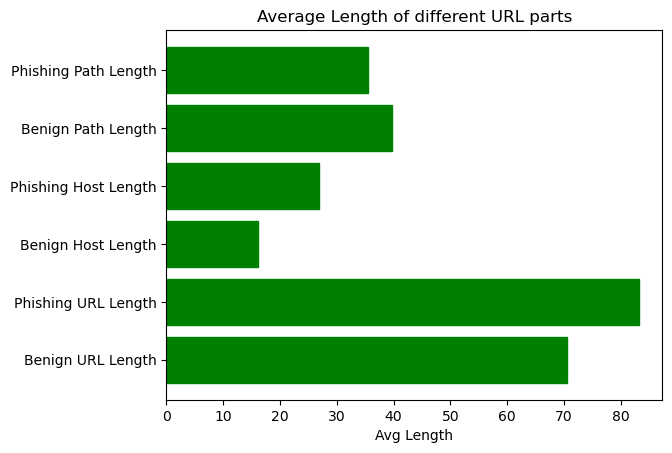

In [8]:
# Calculate the average length for URL, host, path based on label
benign = data[data['label'] == 0]
phishing = data[data['label'] == 1]

benign_url_len = benign['url_length'].mean()
benign_host_len = benign['host_length'].mean()
benign_path_len = benign['path_length'].mean()

phishing_url_len = phishing['url_length'].mean()
phishing_host_len = phishing['host_length'].mean()
phishing_path_len = phishing['path_length'].mean()

LEN_CATEGORIES = ['Benign URL Length', 'Phishing URL Length', 'Benign Host Length', 'Phishing Host Length', 'Benign Path Length', 'Phishing Path Length']
LENGTHS = [benign_url_len, phishing_url_len, benign_host_len, phishing_host_len, benign_path_len, phishing_path_len]

# Create bar graph with the length averages 
plt.barh(LEN_CATEGORIES, LENGTHS, color='green', edgecolor='green')
plt.title('Average Length of different URL parts')
plt.xlabel('Avg Length')
plt.show()

In [9]:
# https://www.statista.com/statistics/265677/number-of-internet-top-level-domains-worldwide/
tld_list = ['com', 'org', 'de', 'ru', 'br', 'net', 'uk', 'jp', 'it', 'fr']

# https://www.kaggle.com/code/vishalxtyagi/url-feature-extractor
shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
            r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
            r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
            r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
            r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
            r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
            r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
            r"tr\.im|link\.zip\.net"

def has_ip(url):
    # Returns 1 if an IP address is found in the URL
    host = urlparse(url).netloc
    try: 
        ipaddress.ip_address(host)
        return 1
    except:
        return 0

def has_http(url):
    # Returns 1 if scheme is http
    parsed_url = urlparse(url)
    return 1 if parsed_url.scheme == 'http' else 0

def has_exe(url):
    # Returns 1 if .exe is found in path
    path = urlparse(url).path
    return 1 if '.exe' in path else 0

def has_www_com(url):
    # Returns 1 if www or com is found in path
    host = urlparse(url).path
    return 1 if 'www' in host or 'com' in host else 0

def has_redirect(url):
    # Returns 1 if double slash is found after protocol, which is at position 7: http://... or https://...
    return 1 if '//' in url[7:] else 0

def top_tld(url):
    # Returns 1 if the TLD of the URL is in tld_list
    parsed_url = urlparse(url)
    tld = parsed_url.netloc.split('.')[-1] # -1 is used to get to the last dot split, which will is the final dot before the TLD
    return 1 if tld in tld_list else 0

def uses_shortening_service(url):
    # Search for any matches in shortening_services 
    return 1 if re.search(shortening_services, url) else 0

# Apply functions to dataframe
data['has_ip'] = data['url'].apply(has_ip)
data['is_http'] = data['url'].apply(has_http)
data['has_www_com'] = data['url'].apply(has_www_com)
data['has_redirect'] = data['url'].apply(has_redirect)
data['has_top_tld'] = data['url'].apply(top_tld)
data['shortening_service'] = data['url'].apply(uses_shortening_service)

data

,url,label,url_length,host_length,path_length,has_ip,is_http,has_www_com,has_redirect,has_top_tld,shortening_service
0,https://oregonstateparks.org/index.cfm?do=geti...,0,80,20,10,0,0,0,0,1,0
1,http://business.hsbc.com.camaract.mobi/system_...,1,137,31,31,0,1,0,0,0,0
2,http://facebook.com-source-page.com/help/conta...,1,66,28,31,0,1,0,0,1,0
3,http://michaelnielsen.org/blog/lecture-course-...,0,74,18,49,0,1,0,0,1,0
4,http://messagerie-17fr.com/fr/91da56ae94f5f4ff...,1,122,19,44,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
468335,http://www.53.com.wps0177m.zarit.tk/confirm/cb...,1,52,28,17,0,1,0,0,0,0
468336,https://www.somethingsimilar.com/2013/12/09/a-...,0,71,24,39,0,0,0,0,1,0
468337,http://tinyurl.com/l8v5dxu,1,26,11,8,0,1,0,0,1,1
468338,http://162.144.71.74/serv/e402b4beddb6aba50327...,1,118,13,46,1,1,0,0,0,0


Now we will look at some countable features

In [10]:
# The special characters are the characters reserved for URIs defined by the RFC3986 standard
CHAR_LIST = [':', '?', '/', '#', '[', ']', '@', '!', '$', '&', '\'', '(', ')', '*', '+', ',', ';', '=', '-', '.', '_', '~']

COLUMN_LIST = ['colon_count', 'question_count', 'slash_count', 'hashtag_count', 'lsb_count', 'rsb_count', 'at_count', 'exclamation_count', 'dollar_count', 'amperstand_count', 'apostrophe_count',
               'left_paranthesis_count', 'right_paranthesis_count', 'asterisk_count', 'plus_count', 'comma_count', 'semicolon_count', 'equal_count', 'dash_count', 'dot_count', 'underscore_count', 'tilde_count']

# This list was created from [https://doi.org/10.1016/j.eswa.2018.09.029] and [https://doi.org/10.1007/978-3-030-20951-3_21]
KEYWORD_LIST = ['limited', 'confirmation', 'page', 'signin', 'team', 'sign', 'access', 'protection', 'active', 'manage', 'secure', 'customer', 'account', 'client', 'information', 'verify', 'recovery', 'secured',
                'business', 'refund', 'help', 'safe', 'bank', 'event', 'giveaway', 'card', 'user', 'device', 'payment', 'shop', 'banking', 'activity', 'admin', 'browser', 'billing', 'protect', 'alert', 'login',
                'gift', 'security', 'confirm', 'info', 'verification', 'check', 'required', 'store', 'remove', 'update', 'configuration', 'support', 'online', 'provider', 'services', 'resolved', 'home',
               'setup', 'center', 'summary', 'contact', 'server', 'solution']

def char_count(url, char):
    # Counts occurances of char in url
    count = url.count(char)
    return count

def digit_count(url):
    # Counts digits in url
    count = sum(c.isdigit() for c in url)
    return count
    
def keyword_count(url):
    # adds 1 to count if any keyword from KEYWORD_LIST is found in url 
    count = sum(1 for k in KEYWORD_LIST if k in url)
    return count

# Zips CHAR_LIST, COLUMN_LIST into a dictionary with keys and values
# ':' gets mapped to 'colon_count', '?' to 'question_count' etc.
dictionary = dict(zip(CHAR_LIST, COLUMN_LIST))

# Apply char_count function for each character
for char, column in dictionary.items():
    data[column] = data['url'].apply(lambda url: char_count(url, char))

# Apply digits and keyword count functions to dataframe
data['digit_count'] = data['url'].apply(digit_count)
data['keyword_count'] = data['url'].apply(keyword_count)

data

,url,label,url_length,host_length,path_length,has_ip,is_http,has_www_com,has_redirect,has_top_tld,...,plus_count,comma_count,semicolon_count,equal_count,dash_count,dot_count,underscore_count,tilde_count,digit_count,keyword_count
0,https://oregonstateparks.org/index.cfm?do=geti...,0,80,20,10,0,0,0,0,1,...,0,0,0,2,0,3,1,0,3,0
1,http://business.hsbc.com.camaract.mobi/system_...,1,137,31,31,0,1,0,0,0,...,0,0,0,1,0,5,1,0,59,1
2,http://facebook.com-source-page.com/help/conta...,1,66,28,31,0,1,0,0,1,...,0,0,0,0,2,2,0,0,16,3
3,http://michaelnielsen.org/blog/lecture-course-...,0,74,18,49,0,1,0,0,1,...,0,0,0,0,5,1,0,0,0,0
4,http://messagerie-17fr.com/fr/91da56ae94f5f4ff...,1,122,19,44,0,1,0,0,1,...,0,0,0,3,1,2,0,0,36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468335,http://www.53.com.wps0177m.zarit.tk/confirm/cb...,1,52,28,17,0,1,0,0,0,...,0,0,0,0,0,5,0,0,6,2
468336,https://www.somethingsimilar.com/2013/12/09/a-...,0,71,24,39,0,0,0,0,1,...,0,0,0,0,4,2,0,0,8,0
468337,http://tinyurl.com/l8v5dxu,1,26,11,8,0,1,0,0,1,...,0,0,0,0,0,1,0,0,2,0
468338,http://162.144.71.74/serv/e402b4beddb6aba50327...,1,118,13,46,1,1,0,0,0,...,0,0,0,2,0,4,0,0,53,0


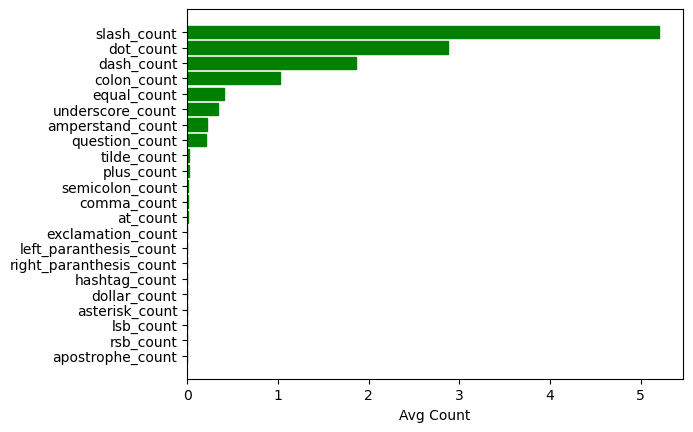

In [11]:
# Calculate the average count of each character in char_list
means = [data[column].mean() for column in COLUMN_LIST]

# Sort the means and columns together
sorted_means, sorted_columns = zip(*sorted(zip(means, COLUMN_LIST)))

# Create bar chart with average count of characters
plt.barh(sorted_columns, sorted_means, color='green', edgecolor='green')
plt.xlabel('Avg Count')

# Save the image
plt.savefig("sc_distribution.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

We can see that most special characters are not present in most URLs. We remove the redunant ones to reduce overhead and keep the top 5 ones:

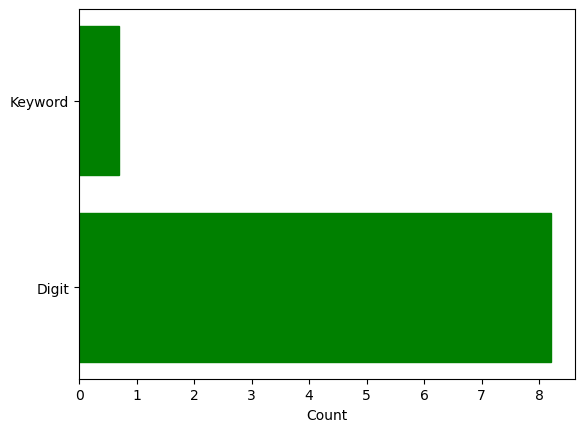

In [12]:
# Calculates average of digits and keywords
avg_digit = data['digit_count'].mean()
avg_keyword = data['keyword_count'].mean()

# Create bar chart with averages above
plt.barh(['Digit', 'Keyword'], [avg_digit, avg_keyword], color='green', edgecolor='green')
plt.xlabel('Count')

# Save image
plt.savefig("dk_distribution.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

In [13]:
def calculate_entropy(url):
    # This functions calculates the entropy of the entire URL
    # p is the probability occurance of each character in the URL: It is the num of character occurances divided by the length of the URL
    p = [url.count(c) / len(url) for c in set(url)]
    # This calculates the entropy using the scipy stats entropy lib with log(2)
    return entropy(p, base=2)

# Apply entropy to dataframe
data['entropy'] = data['url'].apply(calculate_entropy)

data

,url,label,url_length,host_length,path_length,has_ip,is_http,has_www_com,has_redirect,has_top_tld,...,comma_count,semicolon_count,equal_count,dash_count,dot_count,underscore_count,tilde_count,digit_count,keyword_count,entropy
0,https://oregonstateparks.org/index.cfm?do=geti...,0,80,20,10,0,0,0,0,1,...,0,0,2,0,3,1,0,3,0,4.519468
1,http://business.hsbc.com.camaract.mobi/system_...,1,137,31,31,0,1,0,0,0,...,0,0,1,0,5,1,0,59,1,4.826436
2,http://facebook.com-source-page.com/help/conta...,1,66,28,31,0,1,0,0,1,...,0,0,0,2,2,0,0,16,3,4.517212
3,http://michaelnielsen.org/blog/lecture-course-...,0,74,18,49,0,1,0,0,1,...,0,0,0,5,1,0,0,0,0,4.129675
4,http://messagerie-17fr.com/fr/91da56ae94f5f4ff...,1,122,19,44,0,1,0,0,1,...,0,0,3,1,2,0,0,36,0,4.836046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468335,http://www.53.com.wps0177m.zarit.tk/confirm/cb...,1,52,28,17,0,1,0,0,0,...,0,0,0,0,5,0,0,6,2,4.479595
468336,https://www.somethingsimilar.com/2013/12/09/a-...,0,71,24,39,0,0,0,0,1,...,0,0,0,4,2,0,0,8,0,4.458830
468337,http://tinyurl.com/l8v5dxu,1,26,11,8,0,1,0,0,1,...,0,0,0,0,1,0,0,2,0,4.180833
468338,http://162.144.71.74/serv/e402b4beddb6aba50327...,1,118,13,46,1,1,0,0,0,...,0,0,2,0,4,0,0,53,0,4.653499


Now in the next step we can analyze the averages based on the label

In [14]:
benign = data[data['label'] == 0]
# Option to display all columns, normally pandas only displays up to 20 columns
with pd.option_context('display.max_columns', None): 
    print(benign.describe()) 

          label     url_length    host_length    path_length    has_ip  \
count  259750.0  259750.000000  259750.000000  259750.000000  259750.0   
mean        0.0      70.596851      16.149132      39.691553       0.0   
std         0.0      33.946034       4.839271      29.021785       0.0   
min         0.0      13.000000       4.000000       0.000000       0.0   
25%         0.0      47.000000      13.000000      19.000000       0.0   
50%         0.0      63.000000      16.000000      32.000000       0.0   
75%         0.0      86.000000      19.000000      54.000000       0.0   
max         0.0     200.000000      51.000000     187.000000       0.0   

             is_http    has_www_com   has_redirect    has_top_tld  \
count  259750.000000  259750.000000  259750.000000  259750.000000   
mean        0.333759       0.046302       0.003500       0.784570   
std         0.471556       0.210139       0.059053       0.411121   
min         0.000000       0.000000       0.000000       

In [15]:
phishing = data[data['label'] == 1]
with pd.option_context('display.max_columns', None):
    print(phishing.describe())

          label     url_length    host_length    path_length         has_ip  \
count  208590.0  208590.000000  208590.000000  208590.000000  208590.000000   
mean        1.0      83.135697      26.841982      35.563469       0.041315   
std         0.0      48.967254      23.893432      31.387081       0.199019   
min         1.0       4.000000       0.000000       0.000000       0.000000   
25%         1.0      47.000000      15.000000      15.000000       0.000000   
50%         1.0      69.000000      20.000000      27.000000       0.000000   
75%         1.0     104.000000      28.000000      46.000000       0.000000   
max         1.0     200.000000     193.000000     187.000000       1.000000   

             is_http    has_www_com   has_redirect    has_top_tld  \
count  208590.000000  208590.000000  208590.000000  208590.000000   
mean        0.977549       0.114090       0.021741       0.625423   
std         0.148145       0.317921       0.145838       0.484015   
min         

In [16]:
data.to_csv('feature_dataset.csv', index=False)

The next step is to categorize the features. This is important for the Bloom encoder, as it would encode, for example, the integers 79 and 80 differently, although they are similar. 


In [ ]:
# Length features
# Cutoffs are based on mean and 75% quartiles

c_data = data.copy()

def cat_url_length(length):
    # Round to the nearest multiple of 10, if length > 90 then round down to 90
    # Later changed to nearest multiple of 20
    cat = round(length / 20) * 20
    return cat if length <= 90 else 90

def cat_host_length(length):
    # Rounds up to a multiple of 5, cutoff at 25
    cat = round(length / 5) * 5
    return cat if length <= 25 else 25

def cat_path_length(length):
    # Rounds up to a multiple of 10, cutoff at 50
    cat = round(length / 10) * 10
    return cat if length <= 50 else 50

def cat_char_count(url, char):
    # Rounds up to nearest multiple 2, cutoff at 6
    count = url.count(char)
    cat = round(count / 2) * 2
    return cat if count <= 6 else 6

def cat_digit_count(count):
    # Rounds up to nearest multiple of 5, cutoff at 15
    cat = round(count / 5) * 5
    return cat if cat <= 15 else 15

def cat_keyword_count(count):
    # Change keyword counter to binary feature: 1 if any or multiple keywords are found in the URL, else 0
    return 1 if count >= 1 else 0

def cat_entropy(ent):
    # Round anything under 4 to 4, anything over 4.6 to 4.6, anything inbetween to 1 decimal place
    if ent <= 4:
        return 4
    elif ent >= 4.6:
        return 4.6
    else:
        return round(ent, 1)

# The special characters are the characters reserved for URIs defined by the RFC3986 standard
CHAR_LIST = [':', '?', '/', '#', '[', ']', '@', '!', '$', '&', '\'', '(', ')', '*', '+', ',', ';', '=', '-', '.', '_', '~']

COLUMN_LIST = ['colon_count', 'question_count', 'slash_count', 'hashtag_count', 'lsb_count', 'rsb_count', 'at_count', 
               'exclamation_count', 'dollar_count', 'amperstand_count', 'apostrophe_count', 'left_paranthesis_count', 
               'right_paranthesis_count', 'asterisk_count', 'plus_count', 'comma_count', 'semicolon_count', 'equal_count', 
               'dash_count', 'dot_count', 'underscore_count', 'tilde_count']

# Zips CHAR_LIST, COLUMN_LIST into a dictionary with keys and values
# ':' gets mapped to 'colon_count', '?' to 'question_count' etc.
dictionary = dict(zip(CHAR_LIST, COLUMN_LIST))

# Apply char_count function for each character
for char, column in dictionary.items():
    c_data[column] = data['url'].apply(lambda url: cat_char_count(url, char))

c_data['url_length'] = c_data['url_length'].apply(cat_url_length)
c_data['host_length'] = c_data['host_length'].apply(cat_host_length)
c_data['path_length'] = c_data['path_length'].apply(cat_path_length)
c_data['digit_count'] = c_data['digit_count'].apply(cat_digit_count)
c_data['keyword_count'] = c_data['keyword_count'].apply(cat_keyword_count)
c_data['entropy'] = c_data['entropy'].apply(cat_entropy)

# Drop unwanted features
# c_data.drop(columns = ['host_length', 'path_length', 'underscore_count', 'amperstand_count', 'question_count', 
#                       'tilde_count', 'plus_count', 'semicolon_count', 'comma_count', 'at_count', 
#                     'exclamation_count', 'left_paranthesis_count', 'right_paranthesis_count', 'hashtag_count', 'dollar_count', 
#                       'asterisk_count', 'lsb_count', 'rsb_count', 'apostrophe_count', 'entropy',
#                       'equal_count', 'colon_count', 'has_www_com'], inplace=True)

c_data.rename(columns={'keyword_count': 'keyword'}, inplace=True)

c_data

In [ ]:
c_data.to_csv('full_cat_feature_dataset.csv', index=False)

In order for the Bloom encoder to be able to distinguish between certain features, we need to give it a key and a value. For example, if the website has two binary features that are both present (set to 1), the Bloom encoder would encode it the same way. Therefore, we add a key to each feature, such as http1, tld1. This way, the encoder will be able to distinguish between them.

In [ ]:
k_data = pd.read_csv('full_cat_feature_dataset.csv')

# Keys for each feature
keys = ['ur', 'ho', 'pa', 'ip', 'ht', 'ww', 're', 'to', 'ss', 'co', 
        'qu', 'sl', 'ha', 'ls', 'rs', 'at', 'ex', 'dd', 'am', 'ap',  
        'lp', 'rp', 'as', 'pl', 'cc', 'se', 'eq', 'da', 'do', 'un',
        'ti', 'di', 'ke', 'en']

columns = k_data.drop(columns=['url', 'label'])

# This function is used to add keys to each feature. 
# If the value of the feature is not zero, then the key is concatenated with the value. 
# Else it returns None, which is removed later
def add_key(key, value):
    if value > 0:
       return f"{key}{value}"
    else:
    return None
    
for key, column in zip(keys, columns):
    k_data[column] = k_data[column].apply(lambda x: add_key(key, x))

k_data.drop(columns=['host_length', 'path_length', 'has_www_com', 'colon_count', 'question_count',
                     'hashtag_count', 'lsb_count', 'rsb_count', 'at_count', 'exclamation_count', 'dollar_count', 
                     'amperstand_count', 'apostrophe_count', 'left_paranthesis_count', 'right_paranthesis_count', 
                     'asterisk_count', 'plus_count', 'comma_count', 'semicolon_count', 'equal_count', 'underscore_count', 
                     'tilde_count', 'entropy'], inplace=True)

k_data

In [ ]:
labels = k_data['label']
k_data.drop(columns=['label', 'url'], inplace=True)

# Concatenate features to a vector, removing Nones
k_data['features'] = k_data.apply(
    lambda row: [x for x in row if pd.notna(x)], axis=1)

# Put labels and feature vectors back together
key_data = pd.concat([labels, k_data['features']], axis=1)

key_data

In [ ]:
key_data.to_csv('reduced_key_feature_dataset.csv', index=False)